Welcome to Machine Learning!

In [11]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse('1.0.1')
import pandas as pd
import numpy as np

额外的代码，和本节内容无关，主要是用于保存图片

In [12]:
img_path = '../Tex/img/codes/'
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = img_path + f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
housing = pd.read_csv('data/housing.csv')

In [14]:
housing.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20395,-120.46,37.31,26.0,3170.0,572.0,1524.0,565.0,3.4800,95300.0,INLAND
12213,-122.01,37.27,27.0,3340.0,451.0,1220.0,447.0,8.8178,500001.0,<1H OCEAN
3998,-119.23,34.46,34.0,9280.0,1765.0,4514.0,1693.0,3.2026,227600.0,<1H OCEAN
8587,-117.47,33.94,34.0,559.0,139.0,532.0,137.0,3.0687,88500.0,INLAND
10463,-117.88,33.89,18.0,1616.0,532.0,866.0,496.0,3.6435,119100.0,<1H OCEAN


In [15]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [16]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
# housing.describe()
housing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


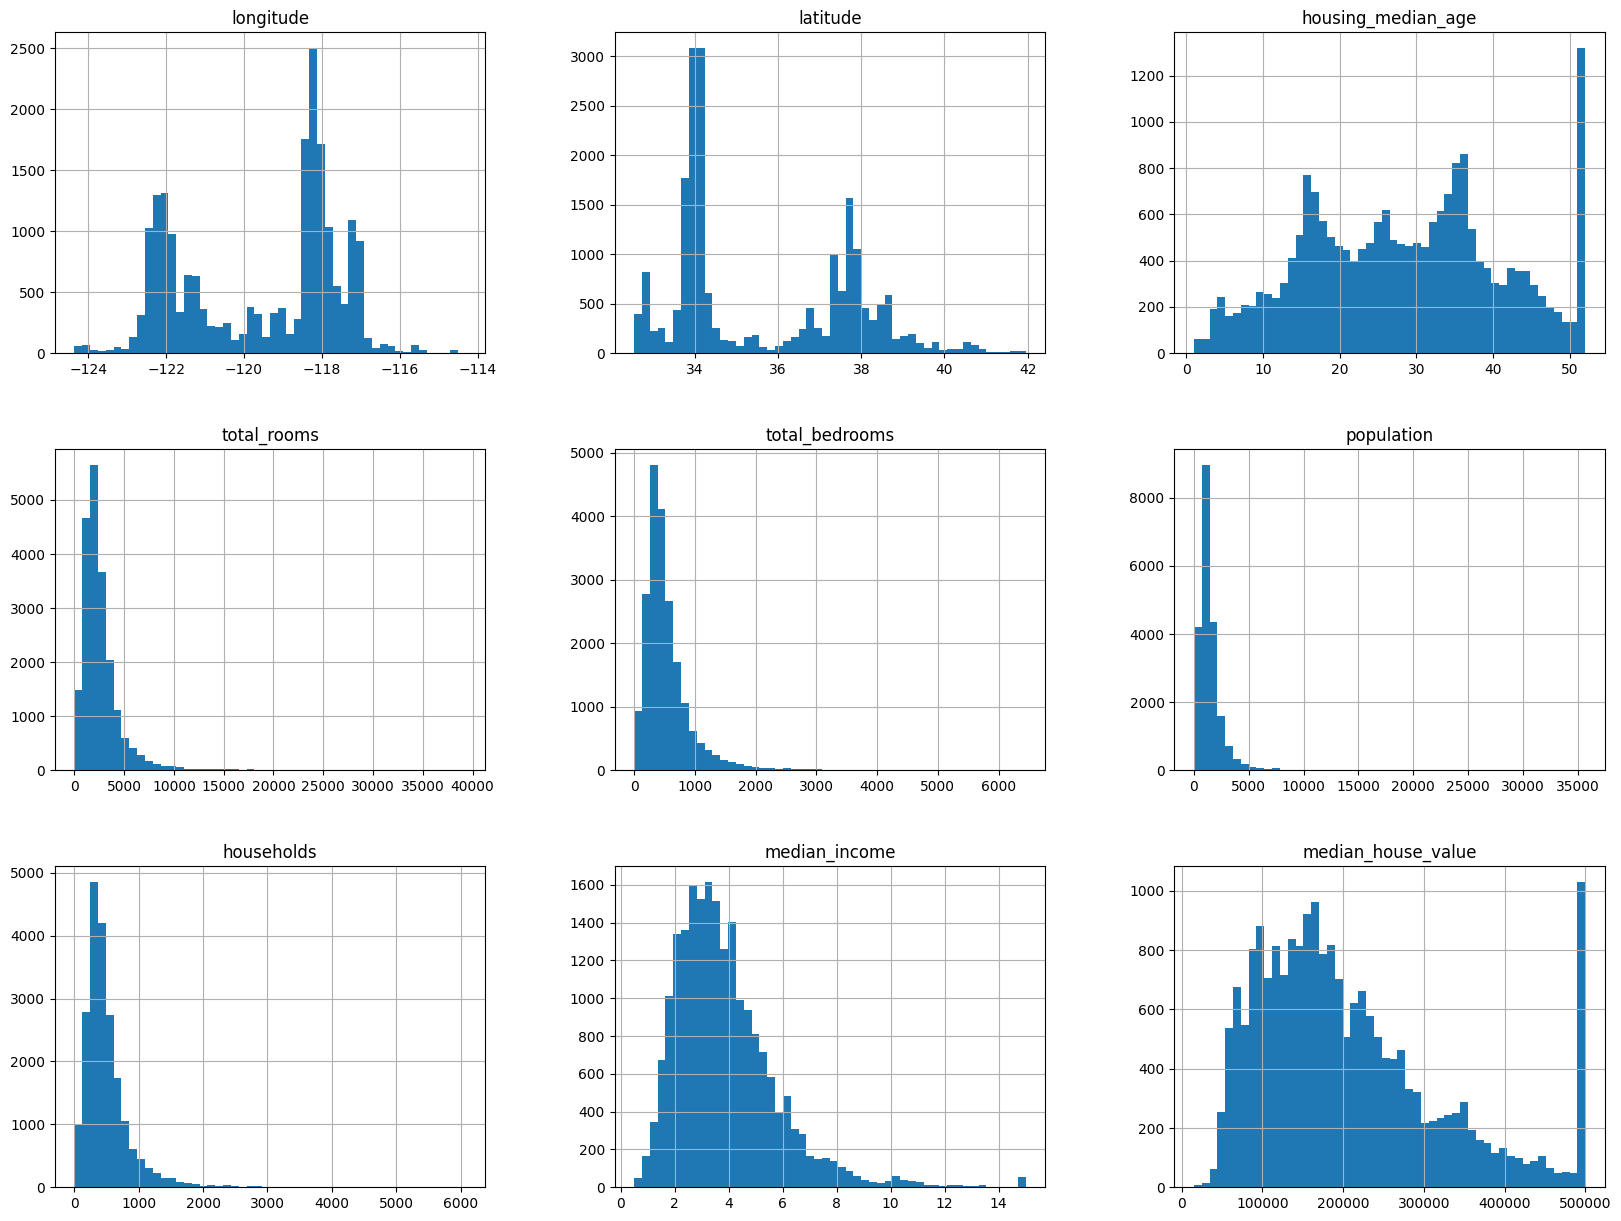

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [19]:
import numpy as np
def split_train_test(data, test_ratio):
    # np.random.seed(39)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size: ]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, .2)
len(train_set), len(test_set)
# (16512, 4128)

(16512, 4128)

In [20]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, .2, 'index')
len(train_set), len(test_set)
# (16512, 4128)

(16512, 4128)

In [21]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, .2, 'id')
len(train_set), len(test_set)

(16322, 4318)

In [22]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)
len(train_set), len(test_set)
(16512, 4128)

(16512, 4128)

In [23]:
from scipy.stats import binom
sample_size = 1000
ratio_female = 0.513
# female less than 485
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
# female more than 535
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.11294380139035708


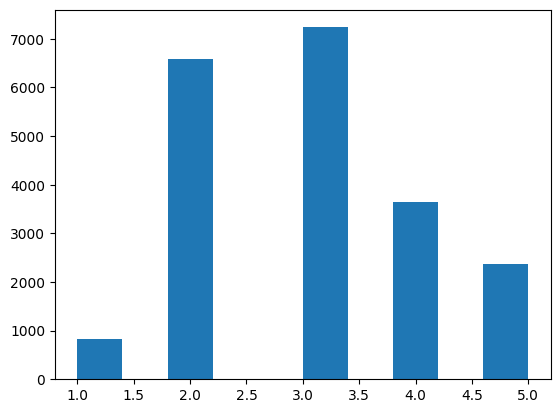

In [24]:
housing['income_cat'] = pd.cut(housing['median_income'],
                                bins=[0, 1.5, 3.0, 4.5, 6, np.inf], 
                                labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist(grid=False)
plt.show()

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [26]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [27]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)
train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)
compare_props = pd.DataFrame({
    'Overall %': income_cat_proportions(housing),
    'Stratifies %': income_cat_proportions(strat_test_set),
    'Random %': income_cat_proportions(test_set)
    }
).sort_index()
compare_props.index.name = 'Income Category'
compare_props['Strat. Error %'] = (compare_props['Stratifies %'] / compare_props['Overall %'] - 1)
compare_props['Rand. Error %'] = (compare_props['Random %'] / compare_props['Overall %'] - 1)
(100 * compare_props).round(2)

,Overall %,Stratifies %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis='columns', inplace=True)

In [29]:
housing = strat_train_set.copy()

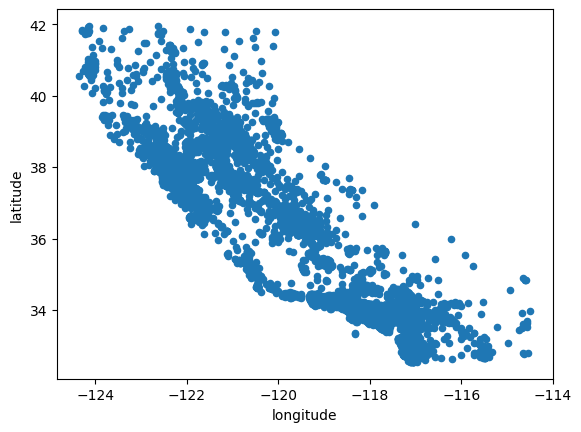

In [30]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

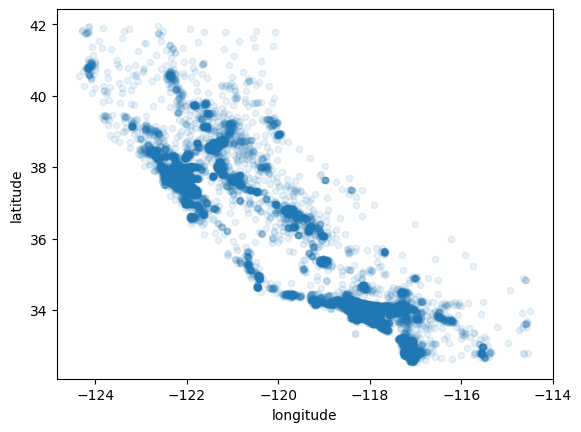

In [31]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.1)
plt.show()

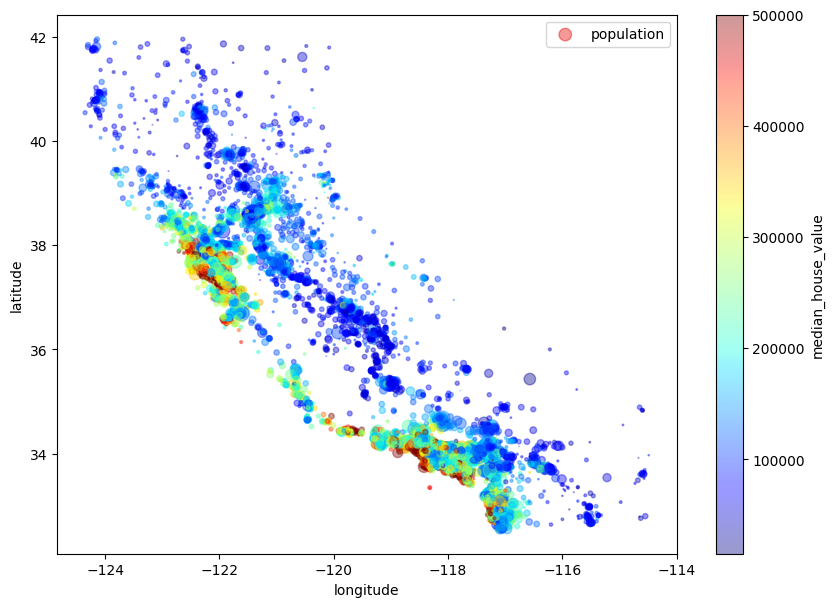

In [35]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.4, s=housing['population']/100,
             label='population', figsize=(10, 7),
             c='median_house_value', cmap='jet', colorbar=True)
plt.legend()
plt.show()

In [36]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

C:\Users\19243\AppData\Local\Temp\ipykernel_10564\2905470689.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

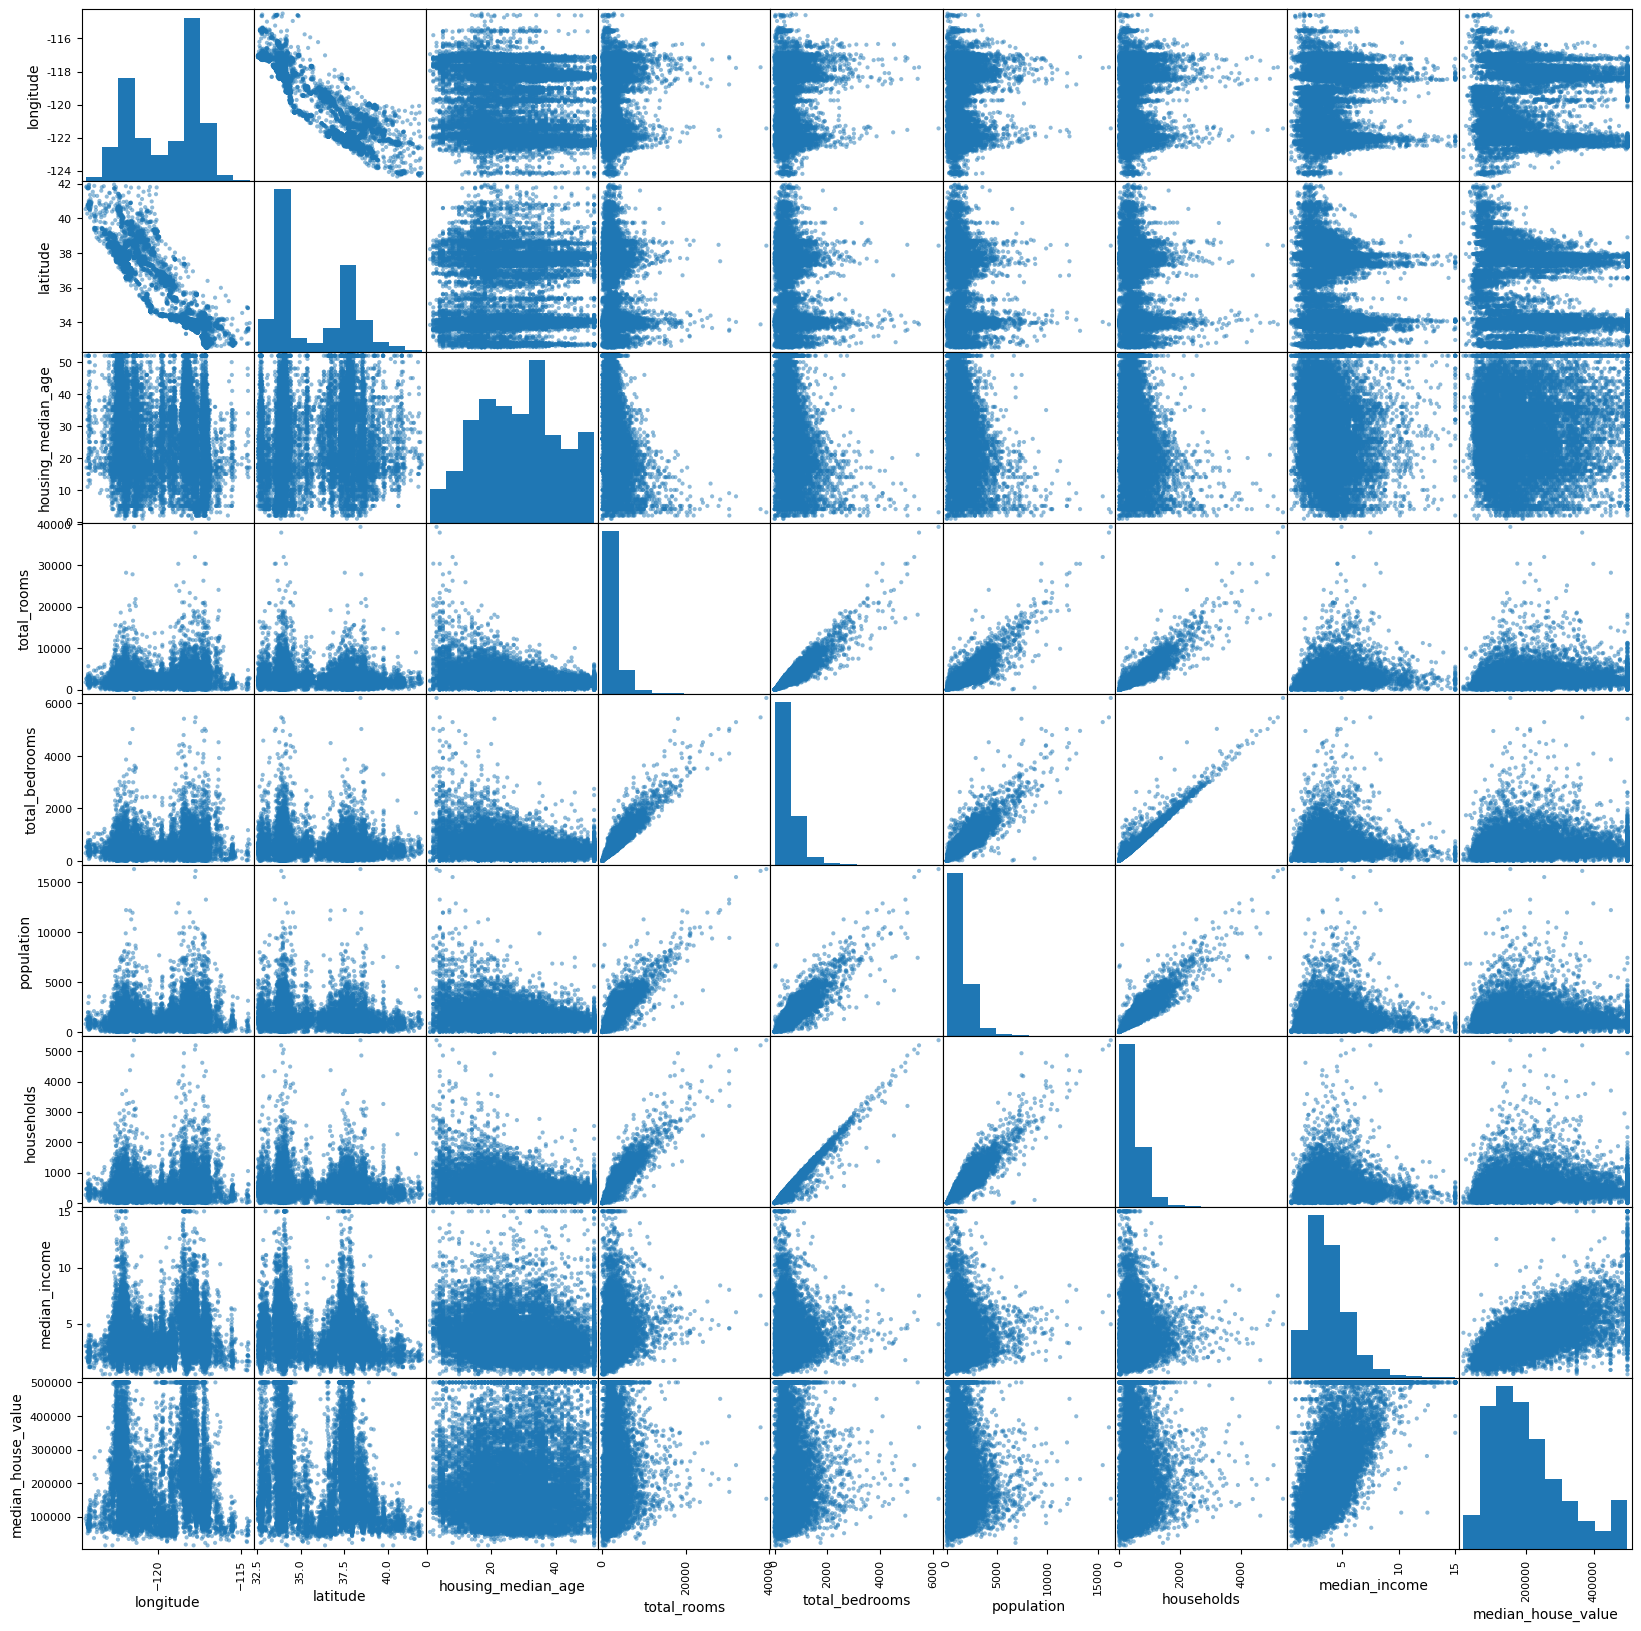

In [37]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing, figsize=(20, 20))
plt.show()

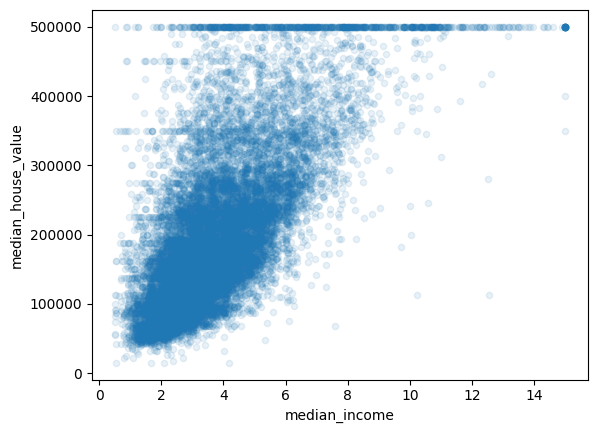

In [38]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.1)
plt.show()

In [39]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [40]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

C:\Users\19243\AppData\Local\Temp\ipykernel_10564\2905470689.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

In [41]:
housing = strat_train_set.drop('median_house_value', axis='columns')
housing_labels = strat_train_set['median_house_value'].copy()

In [42]:
housing.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [43]:
from sklearn.impute import SimpleImputer

In [44]:
imputer = SimpleImputer(strategy='median')

In [45]:
housing_num = housing.drop('ocean_proximity', axis='columns')

In [46]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [47]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [48]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [49]:
X = imputer.transform(housing_num)

In [50]:
housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index=housing_num.index)

In [51]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


## Handling Text and Categorical Attributes

In [52]:
housing_cat = housing[["ocean_proximity"]]

In [53]:
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [54]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [55]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [57]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [58]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
from sklearn.preprocessing import MinMaxScaler

min_max_scalar = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scalar.fit_transform(housing_num)
pd.DataFrame(housing_num_min_max_scaled).sample(3)

,0,1,2,3,4,5,6,7
15060,-0.472617,0.457447,0.098039,-0.914289,-0.894991,-0.894369,-0.875677,-0.724914
7702,0.371197,-0.819149,-0.176471,-0.839005,-0.760992,-0.779904,-0.760687,-0.516186
2206,-0.590264,0.068085,-0.254902,-0.891958,-0.793203,-0.863943,-0.777487,-0.568958


In [60]:
from sklearn.preprocessing import StandardScaler
std_scalar = StandardScaler()
housing_num_std_scalar = std_scalar.fit_transform(housing_num)
pd.DataFrame(housing_num_std_scalar).sample(3)

,0,1,2,3,4,5,6,7
11275,0.271486,-0.130200,0.987087,-0.318230,-0.415122,-0.409691,-0.292514,0.020758
7317,-0.723234,0.910476,0.589800,-0.619801,-0.634540,-0.657233,-0.592889,-1.138301
8250,-1.682963,1.374561,0.351428,-0.507684,-0.643977,-0.637137,-0.652964,0.650185


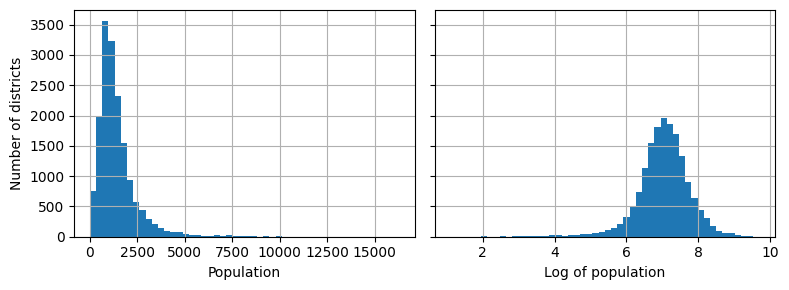

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing['population'].hist(ax=axs[0], bins=50)
housing['population'].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel('Population')
axs[1].set_xlabel('Log of population')
axs[0].set_ylabel('Number of districts')
save_fig('Transforming a feature to make it closer to a Gaussian distribution')
plt.show()

额外的代码

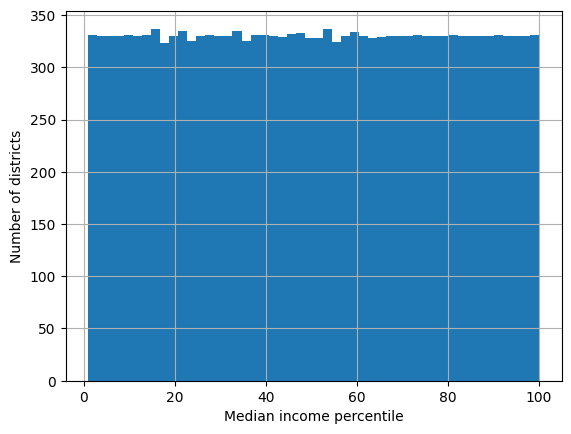

In [62]:
percentiles = [np.percentile(housing.median_income, p) for p in range(1, 100)] 
flattened_median_income = pd.cut(housing.median_income,
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

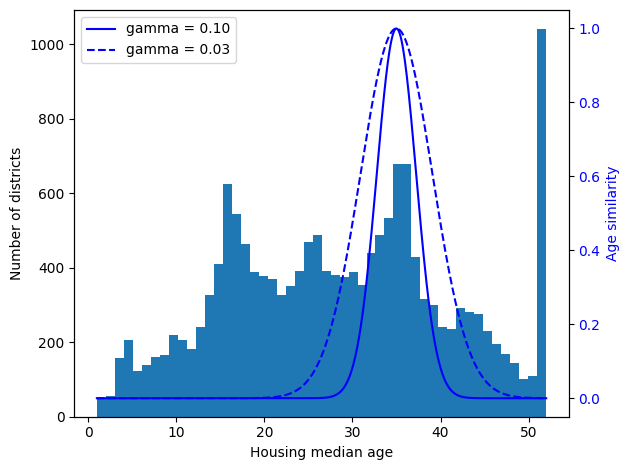

In [63]:
from sklearn.metrics.pairwise import rbf_kernel

# 更一般的情况，是向量与向量之间的RBF，因此需要使用DataFrame
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=.1)

ages = np.linspace(housing['housing_median_age'].min(),
                   housing['housing_median_age'].max(),
                   500).reshape(-1, 1)
gamma1 = .1
gamma2 = .03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Housing median age')
ax1.set_ylabel('Number of districts')
ax1.hist(housing['housing_median_age'], bins=50)

ax2 = ax1.twinx()
color = 'blue'
ax2.plot(ages, rbf1, color=color, label='gamma = 0.10')
ax2.plot(ages, rbf2, color=color, label='gamma = 0.03', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Age similarity', color=color)
plt.legend()

save_fig('Gaussian RBF feature measuring the similarity')
plt.show()

In [64]:
from sklearn.linear_model import LinearRegression

target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
# pretend this is new data
some_new_data = housing[['median_income']].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)
# predictions.flatten()

In [65]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

Let’s create a log-transformer and apply it to the population feature:

In [66]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [67]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35]], gamma=.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [68]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=.1))

sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [69]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1, 2], [3, 4], [5, 6], [6, 7]]))

array([[0.5       ],
       [0.75      ],
       [0.83333333],
       [0.85714286]])

Here’s a custom transformer that acts much like the StandardScaler:

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean
        
    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis='index')
        self.scale_ = X.std(axis='index')
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [71]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=90, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f'Cluster {i} similarity' for i in range(self.n_clusters)]

In [72]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=.1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

In [73]:
similarities[:3].round(2)

array([[0.02, 0.82, 0.05, 0.39, 0.53, 0.78, 0.01, 1.  , 0.19, 0.95],
       [0.95, 0.13, 1.  , 0.46, 0.  , 0.05, 0.72, 0.05, 0.8 , 0.1 ],
       [0.02, 0.88, 0.04, 0.42, 0.63, 0.92, 0.  , 0.96, 0.16, 0.89]])

额外的代码

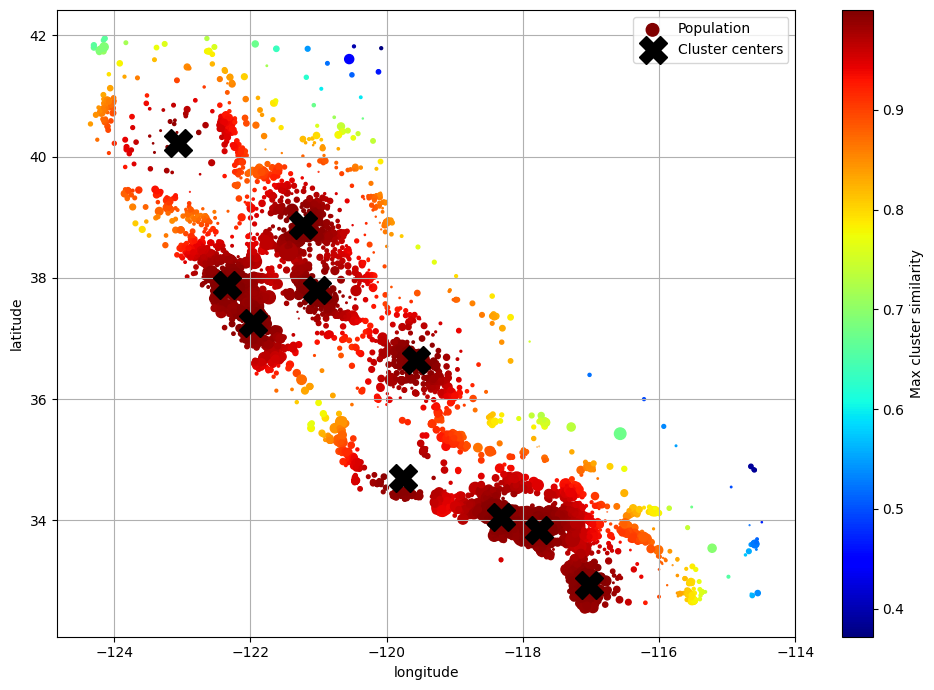

In [74]:
housing_copy = housing.copy()
housing_copy['Max cluster similarity'] = similarities.max(axis=1)

housing_copy.plot(kind='scatter', x='longitude', y='latitude', grid=True,
                  s=housing_copy['population'] / 100, label='Population',
                  c='Max cluster similarity',
                  cmap='jet', colorbar=True,
                  legend=True, sharex=True, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle='', color='black', marker='X', markersize=20,
         label='Cluster centers')
plt.legend(loc='upper right')
save_fig('Gaussian RBF similarity to the nearest cluster center')
plt.show()

### Transformation Pipelines


In [83]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

In [81]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())